<a href="https://colab.research.google.com/github/yahavmh/My_VGG16/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import scipy.io
import numpy as np
import random
from keras import backend as K
import keras
from keras.preprocessing import image
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from os import path
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
from xml.etree import ElementTree
import imutils
from PIL import *
from keras.utils import np_utils
import os




## adding gaussian noise in the augmentation process
def add_noise(img):
  rand = random.uniform(0, 1)
  if(rand > 0.5):
    mean = 0.0   # mean
    var = 0.1  
    std = var**0.5  #  standard deviation
    noisy_img = img + np.random.normal(mean, std, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255).astype(np.float32)
    return noisy_img_clipped
  else:
    return img   


## removing background to keep only green objects in image using HSV filter
def background_removal(img):
  hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
  mask = cv2.inRange(hsv, (30, 25, 25), (70, 255,255))

  ## slice the green
  imask = mask>0
  green = np.zeros_like(img, np.uint8)
  green[imask] = img[imask]
  return green 

## preprocess data for VGG16
def preprocess(data):
  images = []
  for img in data: ## getting each image ready for VGG16 network
    img = cv2.resize(img, (224, 224)) ## VGG16 demands iamge shape of (224,224,3)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    images.append(img)
  images = np.array(images)
  images = np.rollaxis(images, 1, 0)
  images = images[0]
  return images
  

# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = []
    labels= []
    
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        
        coordinates = [xmin, ymin, xmax, ymax]
        boxes.append(coordinates)
    
    for name in root.iter('object'):
        label = 1
        obj = name.find('name').text
        if obj == 'corn': 
            label = 0
        labels.append(label)
  
    return boxes, labels


def read_data(images_path,xml_path):
    ## Reading the images and labels file and distributing them to the train and test set
    data = {'images': [],'class': []}
    os.chdir(images_path)
    num_of_images = len([name for name in os.listdir('.') if os.path.isfile(name)]) ## number of images in dataset
    print( "Number of images in the datase:", num_of_images)

    for i in range(int(num_of_images)): ## iterating on every image and its corresponding xml file
        image_path = images_path + str(i) + '.JPG'
        xml_file_path =  xml_path + str(i) + '.xml'
       
        if (path.exists(image_path) and path.exists(xml_file_path)): ## make sure we dont upload null
            img = cv2.imread(image_path)  ## Read img
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = background_removal(img)
            height, width, channels = img.shape
            boxes, labels = extract_boxes(xml_file_path) ## extract coordinates and labels from xml file
            
            for b in range(len(boxes)):
                box = boxes[b]
                label = labels[b]
                xmin = box[0]
                xmax = box[2]
                ymin = box[1]
                ymax = box[3]
                if((xmax-xmin)>0 and (ymax-ymin)>0): ## for boxes annotated on mistake
                    image = img[ymin:ymax,xmin:xmax]
                    image = cv2.resize(image, (224, 224)) ## VGG16 demands iamge shape of (224,224,3)
                    data['images'].append(image)
                    data['class'].append(label)
    return data

Using TensorFlow backend.


In [ ]:
#here change path to your Images and XML files dir
images_path = '/content/drive/My Drive/Colab Notebooks/Images/'
xml_path = '/content/drive/My Drive/פרוייקט גמר/XML/'

print("Reading data...(might take a few minuets)")
data = read_data(images_path,xml_path)
print("Number of annotated object in the dataset:", len(data['class']))

Reading data...(might take a few minuets)
Number of images in the datase: 118
Number of annotated object in the dataset: 19438


In [ ]:
## extarcting images and labels from dictionry
images = data['images']
labels = data['class']
num_classes = 2 ## number of classes. 2 in my project for weeds and corns
labels = np_utils.to_categorical(labels, num_classes) ## converting lables to categorical 0 and 1

In [ ]:
#### splitting data into train, validation and test randomally ####

print("Splitting data into train and test")
X_training, X_test, y_training, y_test = train_test_split(images, labels, test_size=0.3, shuffle=1)
print("Splitting data into train and validation")
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, shuffle=1)

## saving some RAM space
del(images)
del(data)
del(labels)

Splitting data into train and test
Splitting data into train and validation


In [ ]:
#### preprocessing the images as reuired for vgg16 ####
## train set rescaling will be performed in the augmentation due to the gaussian noise addition
print("preprocessing train images")
X_train = preprocess(X_train)
print("preprocessing vallidation images")
X_val = preprocess(X_val)/255
print("preprocessing test images")
X_test = preprocess(X_test)/255

preprocessing train images
preprocessing vallidation images
preprocessing test images


In [ ]:
#### making custom metrix for measures - F1 score, Presicion and Recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
## using transfer learning to train VGG16 netowrk with the addition of 2 layers of batch
## normalization and dropout in the FC layers

from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization


def build_model(retrainable_layers,lr,lr_decay,dropout):
    ## Builds a VGG16 model with specified number of retrainable layers
    model = VGG16(weights='imagenet', include_top=True,pooling='max')
    model.layers.pop()
    last_layer = Dense(2, activation='sigmoid',  name='output_layer') ## Insert output layer
    out = last_layer(model.layers[-1].output)
    model = Model(inputs=model.input, outputs=out)

    for layer in model.layers[:-(retrainable_layers)]: ## Make specified number of layers retrainable
        layer.trainable = False
 
    #extracting the 3 fc layers
    fc1 = model.layers[-3]
    fc2 = model.layers[-2]
    predictions = model.layers[-1]

    # Create the dropout layers
    dropout1 = Dropout(dropout)
    dropout2 = Dropout(dropout)

    # Reconnect the layers
    x = dropout1(fc1.output)
    x = BatchNormalization()(x)
    x = fc2(x)
    x = dropout2(x)
    x = BatchNormalization()(x)
    predictors = predictions(x)
    model2 = Model(inputs=model.input, outputs=predictors)

    sgd = SGD(lr=lr, decay=lr_decay, nesterov=True) ## values for the stochastic gradient decent
    model2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy',f1_m,precision_m, recall_m])
    return model2


def train_model(X_train,X_val,Y_train,Y_val,retrainable_layers,batchSize,lr,lr_decay,dropout):
    History = keras.callbacks.History()
    print("Building model with VGG16 net")
    model = build_model(retrainable_layers,lr,lr_decay,dropout)
    print("Done building model")

    ## augmentation for the train dataset
    train_aug = ImageDataGenerator( 
      rescale = 1.0/255.0,
       rotation_range=30,
       zoom_range=0.15,
       width_shift_range=0.2,
       height_shift_range=0.2,
       shear_range=0.15,
       horizontal_flip=True,
       preprocessing_function = add_noise, ## adding gaussian noise to improve model generalization
       fill_mode="nearest")
      
    model_path = "/content/drive/My Drive/black_noisy_vgg16_model.h5" ## path to model checkpoint 
    checkpoint = ModelCheckpoint(model_path, monitor='val_f1_m', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)

    history = model.fit_generator(train_aug.flow(X_train, Y_train, batch_size=batchSize), epochs=5, validation_data=(X_val, Y_val), callbacks=[History,checkpoint])
    print("Done training model")
    return model



In [ ]:
## Building our model, and training it with the train data
model = train_model(X_train,X_val,y_train,y_val, retrainable_layers=8, batchSize=16,lr=0.01,lr_decay=0.0005,dropout=0.5)

Building model with VGG16 net
Done building model
Epoch 1/5
681/681 [==============================] - 152s 223ms/step - loss: 0.2168 - accuracy: 0.9233 - f1_m: 0.9232 - precision_m: 0.9237 - recall_m: 0.9240 - val_loss: 0.0619 - val_accuracy: 0.9792 - val_f1_m: 0.9793 - val_precision_m: 0.9806 - val_recall_m: 0.9781

Epoch 00001: val_f1_m improved from -inf to 0.97928, saving model to /content/drive/My Drive/black_noisy_vgg16_model.h5
Epoch 2/5
681/681 [==============================] - 146s 214ms/step - loss: 0.1554 - accuracy: 0.9482 - f1_m: 0.9483 - precision_m: 0.9489 - recall_m: 0.9486 - val_loss: 0.1020 - val_accuracy: 0.9726 - val_f1_m: 0.9728 - val_precision_m: 0.9720 - val_recall_m: 0.9737

Epoch 00002: val_f1_m did not improve from 0.97928
Epoch 3/5
681/681 [==============================] - 145s 213ms/step - loss: 0.1327 - accuracy: 0.9562 - f1_m: 0.9554 - precision_m: 0.9563 - recall_m: 0.9555 - val_loss: 0.0463 - val_accuracy: 0.9829 - val_f1_m: 0.9830 - val_precision_m: 

In [ ]:
## Getting predictions according to our model
print("Getting predictions on test dataset")
predicts = model.predict(X_test)
print("Evaluating Model")
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)
print("model accuracy is:",accuracy*100,"%")
print("model f1_score is:",f1_score*100,"%")
print("model precision is:",precision*100,"%")
print("model recall is:",recall*100,"%")

Getting predictions on test dataset
Evaluating Model
5832/5832 [==============================] - 15s 3ms/step
model accuracy is: 98.43964576721191 %
model f1_score is: 98.44574928283691 %
model precision is: 98.44700694084167 %
model recall is: 98.44603538513184 %


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


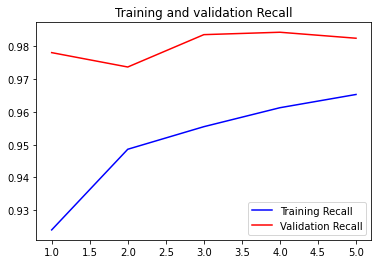

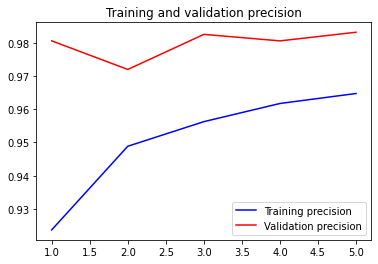

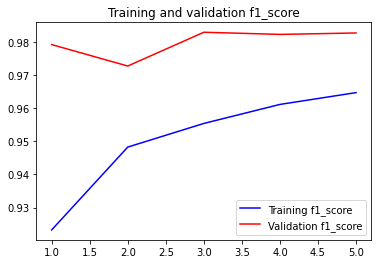

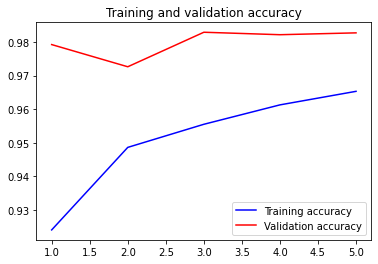

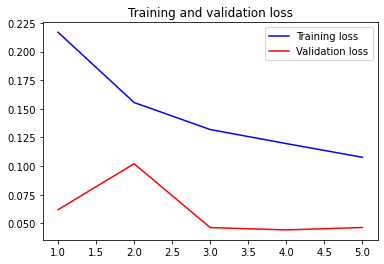

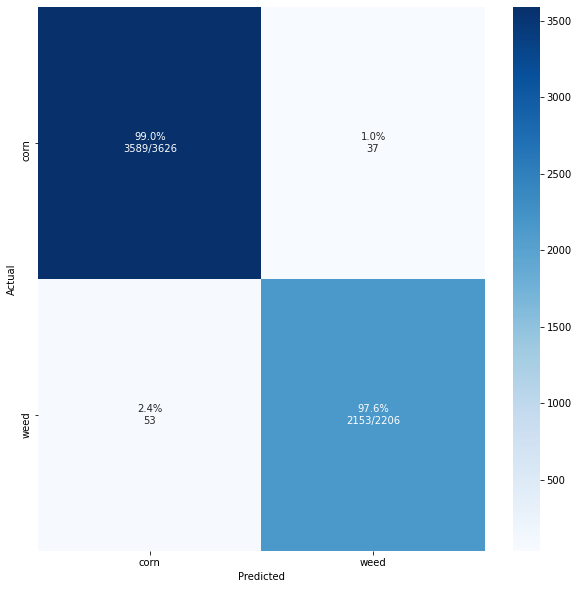

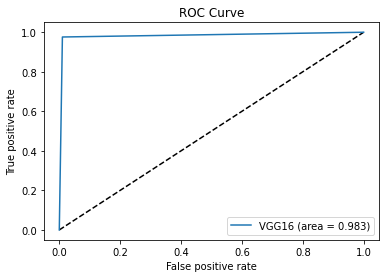

In [ ]:

##### plotting ROC Curve, Confusion Matrix and all metric train vs validation scores


##plot Recall
history = model.history
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
epochs = range(1,len(recall)+1)
plt.figure()
plt.plot(epochs, recall, 'b', label = 'Training Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()
#plt.savefig('/content/drive/My Drive/black_noisy_train_val_recall.png', dpi=1200)

##plot Precision
prc = history.history['precision_m']
val_prc = history.history['val_precision_m']
epochs = range(1,len(recall)+1)
plt.figure()
plt.plot(epochs, prc, 'b', label = 'Training precision')
plt.plot(epochs, val_prc, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
#plt.savefig('/content/drive/My Drive/black_noisy_train_val_precision.png', dpi=1200)

##plot f1_score
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
epochs = range(1,len(recall)+1)
plt.figure()
plt.plot(epochs, f1, 'b', label = 'Training f1_score')
plt.plot(epochs, val_f1, 'r', label='Validation f1_score')
plt.title('Training and validation f1_score')
plt.legend()
#plt.savefig('/content/drive/My Drive/black_noisy_train_val_f1_score.png', dpi=1200)

##plot accuracy and loss
acc = history.history['recall_m']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('/content/drive/My Drive/black_noisy_train_val_acc.png', dpi=1200)

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig('/content/drive/My Drive/black_noisy_Loss.png', dpi=1200)

# confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
def cm_analysis(cm,y_true, y_pred, labels, ymap=None, figsize=(10,10)):

    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap=plt.cm.Blues)
    #plt.savefig('/content/drive/My Drive/black_noisy_cm.png',bbox_inches = 'tight', dpi=1200)
    plt.show()


cm=confusion_matrix(y_test.argmax(axis=1), predicts.argmax(axis=1))
cm_analysis(cm,y_test, predicts.round(),['corn','weed'], ymap=None, figsize=(10,10))

#ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.argmax(axis=1), predicts.argmax(axis=1))
auc_keras = auc(fpr_keras, tpr_keras)

## plotting ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='VGG16 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.title('ROC Curve')
#plt.savefig('/content/drive/My Drive/black_noisy_roc_curve.png', dpi=1200, bbox_inches = 'tight')
plt.show()

In [ ]:
### loading model from checkpoint location
from keras.models import load_model
custom_objects = {"f1_m": f1_m,"recall_m":recall_m,"precision_m":precision_m } ## for custom metric 
model_path = "/content/drive/My Drive/black_noisy_vgg16_model.h5"
model = load_model(model_path,custom_objects = custom_objects)

In [ ]:
## plotting the model's architecture
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/model_plot.png', show_shapes=True, show_layer_names=True, dpi = 400)

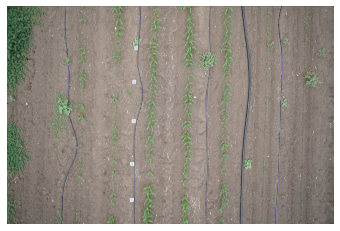

In [ ]:
## load and plot original image
img_path = '/content/drive/My Drive/Colab Notebooks/Images/75.JPG'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

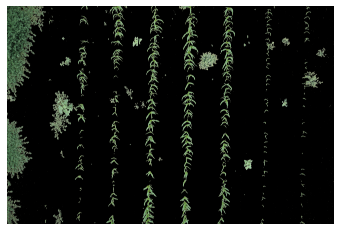

In [ ]:
## ## load and plot image after background removal
img_path = '/content/drive/My Drive/Colab Notebooks/Images/75.JPG'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = background_removal(img)
image = plt.imshow(img)
plt.axis('off')
plt.imshow(img)

In [ ]:
## preprocess for the inference part
def inference_preprocess(img):
  img = cv2.resize(img, (224, 224)) ## VGG16 demands iamge shape of (224,224,3)
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  img = img/255
  return img
  

In [ ]:
## creating Hue threshold in the cell depending on the cell size
def hue_threshold_maker(tile_height):
  if (tile_height ==100):
    LB = 0.01
    UB = 1
  elif (tile_height ==200):
    LB = 0.001
    UB = 1
  else:
   LB = 0.0001
   UB = 1

  return LB,UB


## getting average Saturation and Hue levels in the cell
def hue_thresh(img):
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  H = hsv[:,:,0]
  avg_hue = (H>0).mean()
  return avg_hue

In [ ]:
## a recursive function that devides the inference image into cells of 600x400 reolution,
## finds ROI in images due to the green level defined by the average Hue levels in each cell;
##if the cell holds the threshold, the cell size is divided by 2 re-enters the function with the new cell size.
## if a cell is of 150x100 resolution (stopping condition), and holds the green levels thresholds,
## a prediction is being made for the containment of weeds in this cell, and paint the image part contating weeds in white. 

def recursive_paint_weeds(img, division_factor, is_weed = False):

  height, width, channels = img.shape

  if(height == 100): ## stopping condition
    if(is_weed == True): ## if a cell contating a weed
      return 255 ## paint in white
    else:
      return img ## do nothing

  tile_height = int(height/division_factor) ## cell size and width recursivley divided by 2
  tile_width = int(width/division_factor)

 
  for x in range(int(width/tile_width)): ## dividing the image into cells
    for y in range(int(height/tile_height)):

      part_image = img[y*tile_height:(y+1)*tile_height, x*tile_width:(x+1)*tile_width] ## extracting cells from the image
      LB1, UB1 = hue_threshold_maker(tile_height) ## getting hue levels threhold
      avg_hue = hue_thresh(part_image) ## getting hue and saturation levels in the cell

      if(LB1 <= avg_hue <= UB1): ## if the cell holds the average hue threshold
        if (tile_width == 150): ## if a cell is in the size for prediction
          tile = inference_preprocess(part_image) ## preprocess cell for VGG16
          prediction = model.predict(tile) ## getting classes probabilities
          weed_prediction = prediction[0][1] ## probability of a tile being weed
          corn_prediction = prediction[0][0] ## probability of a tile being corn
          alpha = 0.3 ## setting the statistical significance
          confidence_level = 1 - alpha ## confidence level
          if weed_prediction > confidence_level and corn_prediction <= alpha:
              img[y*tile_height:(y+1)*tile_height,x*tile_width:(x+1)*tile_width] = recursive_paint_weeds(part_image, division_factor=2, is_weed=True)
        else:
          img[y*tile_height:(y+1)*tile_height,x*tile_width:(x+1)*tile_width] = recursive_paint_weeds(part_image, division_factor=2, is_weed=True) ## continue the recurssion
  return img

6.35150408744812


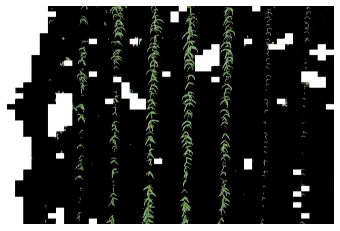

In [ ]:
import time

img_path = '/content/drive/My Drive/Colab Notebooks/Images/75.JPG' ## image for inference
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
start = time.time() ## start timer
img = background_removal(img) ## removing all none-green pixels
img = recursive_paint_weeds(img, division_factor=10) ## start with image size 600x400
end = time.time() ## stop timer
print(end - start) ## printing the time it took to map all the weeds in the image
plt.axis('off')
plt.imshow(img)
#plt.savefig('/content/drive/My Drive/35_painted_image.png', dpi=1200, bbox_inches = 'tight')

In [ ]:
## loading the two images that used for inference

img_path = '/content/drive/My Drive/Colab Notebooks/Images/35.JPG'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_path2 = '/content/drive/My Drive/Colab Notebooks/Images/75.JPG'
img2 = cv2.imread(img_path2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

10088057047
9451678973


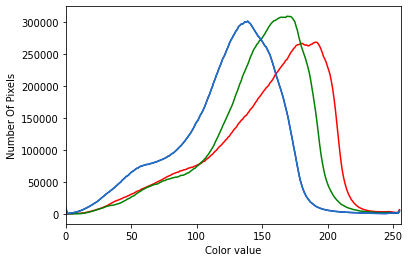

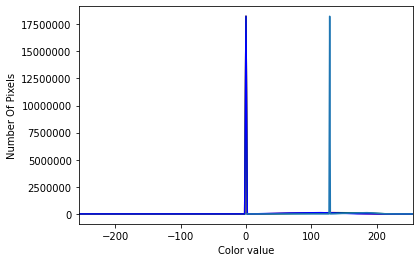

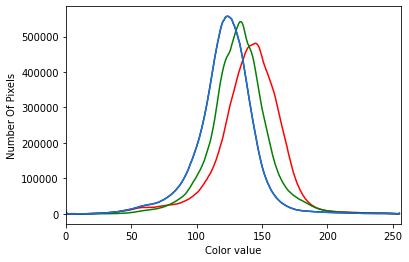

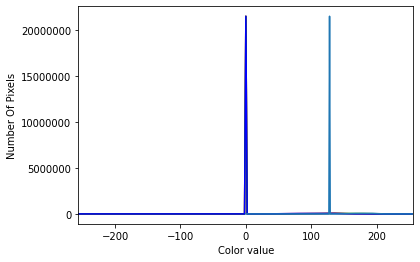

In [ ]:
#### creating histograms of pixels disturbution for inference images
## both for original images and for images after background removal


# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')

plt.xlim([0, 256])
print(img.sum())
print(img2.sum())

for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Number Of Pixels")
plt.plot(histogram)
#plt.savefig('/content/drive/My Drive/35_hist.png', dpi=1200, bbox_inches='tight')

fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')

# tuple to select colors of each channel line

plt.xlim([-256, 256])

img3 = background_removal(img)
# create the histogram plot, with three lines, one for
# each color
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img3[:, :, channel_id], bins=256, range=(-256, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)
plt.plot(histogram)
plt.xlabel("Color value")
plt.ylabel("Number Of Pixels")

#plt.savefig('/content/drive/My Drive/35black_hist.png', dpi=1200, bbox_inches='tight')
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')
# tuple to select colors of each channel line
# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])

for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img2[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Number Of Pixels")
plt.plot(histogram)

#plt.savefig('/content/drive/My Drive/75_hist.png', dpi=1200, bbox_inches='tight')


img4 = background_removal(img2)

# tuple to select colors of each channel line
# create the histogram plot, with three lines, one for
# each color
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')
plt.xlim([-256, 256])

for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img4[:, :, channel_id], bins=256, range=(-256, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Number Of Pixels")
plt.plot(histogram)
#plt.savefig('/content/drive/My Drive/75black_hist.png', dpi=1200, bbox_inches='tight')

